# 1. Zero Point

To perform photometry I will be using the python package photoutils. This will take a set of coordinates and specified radii to determine the flux of the area in counts per second. This measured flux is highly dependent on the telescope and CCD, meaning that I will have to convert it to a standard measurement of magnitude, in the case of this project: the AB system.
 
In order to do this, I will need the **zero point**, which can be found by measuring the flux of a **standard star** or well studied star with known magnitude. With these two values, the zero point is determined by simply taking the difference between the known AB magnitude and the measured instrumental magnitude.

$M_{ZP} = M_{AB} - M_I$

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import Functions.general_functions as gen
import Functions.photometry_functions as photo

Load calibrated standard star images, I'll be using the star +2 2711

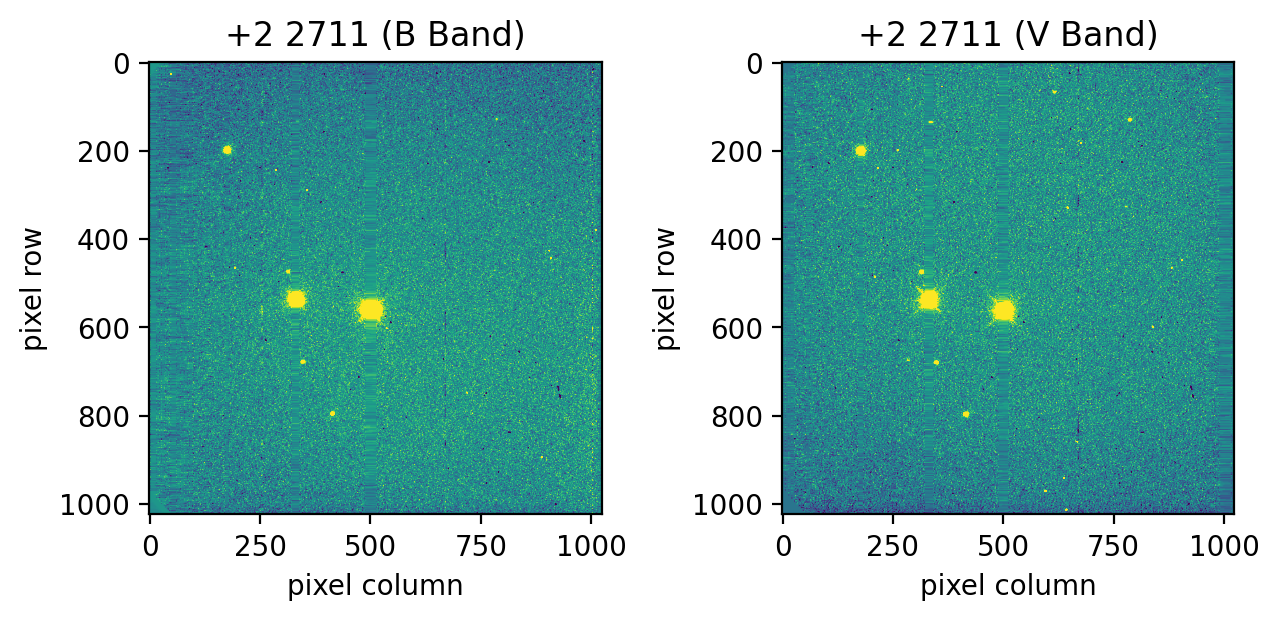

In [2]:
# star image
standard_star_b = fits.getdata('Data/Clean/Sci/+2 2711/B/Sci_1.fits')
standard_star_v = fits.getdata('Data/Clean/Sci/+2 2711/V/Sci_1.fits')
# error
standard_star_b_err = fits.getheader('Data/Clean/Sci/+2 2711/B/Sci_1.fits')['ERROR']
standard_star_v_err = fits.getheader('Data/Clean/Sci/+2 2711/V/Sci_1.fits')['ERROR']

# plot
plt.figure(figsize=(7,4),dpi=200)
plt.subplots_adjust(wspace=0.4,hspace=0.4)
plt.subplot(121)
gen.see_image(standard_star_b)
plt.title('+2 2711 (B Band)')
plt.subplot(122)
gen.see_image(standard_star_v)
plt.title('+2 2711 (V Band)');

# Perform Photometry
Use photometry to find the flux in counts per seconds

In [3]:
# Tried to copy those of Landolt
coord = (506.,561.)
radius = 19.02

phot_b,err_b = photo.photometry(standard_star_b,standard_star_b_err,coord,radius)
phot_v,err_v = photo.photometry(standard_star_v,standard_star_v_err,coord,radius)

Then convert this to the instumental magnitude using the equation $M_I = -2.5\log_{10}(N)$ where *N* is the counts per second

In [4]:
inst_mag_b = photo.count_to_inst_mag(phot_b,err_b)
inst_mag_v = photo.count_to_inst_mag(phot_v,err_v)

# Find AB Magnitude
There are plenty of charts online that have the AB magnitudes of a standard stars. I'm going to be using the ESO's chart of [Landolt Equatorial Standards](https://www.eso.org/sci/observing/tools/standards/Landolt.html). 

I'll start by collecting the information from the webpage and creating a dataframe to store it all in.

In [5]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.eso.org/sci/observing/tools/standards/Landolt.html'

html = requests.get(url).text
soup = BeautifulSoup(html, 'html.parser')

tables = soup.findAll({'tbody'})[1:-1]
chart = pd.DataFrame(columns=['Star','Chart','RA2000','DEC2000','V','B-V','U-B',
                              'V-R','R-I','V-I','n','m','e_V','e_B-V','e_U-B',
                              'e_V-R','e_R-I','e_V-I'])

for table in tables:
    column_names = table.findAll({'tr'})[0]
    column_names = [col.text for col in column_names.findAll({'td'})]
    rows = table.findAll({'tr'})[2:]
    for row in rows:
        columns = row.findAll({'td'})
        columns = [col.text for col in columns]
        chart = chart.append(dict(zip(column_names,columns)),ignore_index=True)
        
chart['Star'] = chart['Star'].str.replace(' ','')

look up and save the entry for +2 2711.

In [6]:
standard_star = chart[chart['Star'] == '+22711']
standard_star

,Star,Chart,RA2000,DEC2000,V,B-V,U-B,V-R,R-I,V-I,n,m,e_V,e_B-V,e_U-B,e_V-R,e_R-I,e_V-I
314,+22711,PLUS2.gif,13 42 20,+01 29 58,10.37,-0.166,-0.697,-0.072,-0.095,-0.167,54,39,0.0012,0.0014,0.0018,0.0008,0.001,0.0012


calculate the values of B and V (-0.009 and 0.02 are constants)

In [7]:
v_mag = float(standard_star['V'])+0.02
b_mag = float(standard_star['B-V'])+v_mag-0.09

b_mag,v_mag

(10.133999999999999, 10.389999999999999)

# Zero Point
With this, we can find the zero-point with our standard star which will help up find the AB magnitude of M67!

In [8]:
zero_point_b = b_mag - inst_mag_b[0]
zero_point_v = v_mag - inst_mag_v[0]

zero_point_b_err = inst_mag_b[1]
zero_point_v_err = inst_mag_v[1]

zero_points = {'B':{'zero_point':zero_point_b,'zero_point_err':zero_point_b_err},
               'V':{'zero_point':zero_point_v,'zero_point_err':zero_point_v_err}}

with open('Data/zero_points.json', 'w') as fp:
    json.dump(zero_points, fp) 
    
print('Zero Point for B band: %.2f + %.2f' % (zero_point_b,zero_point_b_err))
print('Zero Point for V band: %.2f + %.2f' % (zero_point_v,zero_point_v_err))

Zero Point for B band: 21.55 + 5.50
Zero Point for V band: 21.98 + 4.60
